<a href="https://colab.research.google.com/github/nosgueira/PLN-2022-1/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_PLN_W2V_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Using Word2Vec (Transfer Learning)

In [ ]:
!pip install -qU gensim

     |████████████████████████████████| 24.1 MB 1.2 MB/s 


## Imports

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.downloader



from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.stats import loguniform
import nltk
import pandas as pd
import numpy as np

import re

nltk.download('punkt')
nltk.download('stopwords')

# Defining stop words
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##  Data processing

### Loading data

In [ ]:
corpus = pd.read_csv('https://query.data.world/s/aikveq4giwygvkn4wyirtwiqwmyc7q')

In [ ]:
corpus

,Unnamed: 0,tweet_category,user,location,date,text
0,0,1,dflenick,"Davie, FL",2020-02-11 20:03:56,b'RT @TribulationThe: Deep State Dems continue...
1,1,1,RestartMIGA6,NaN,2020-02-11 20:03:54,b'RT @restartleader: The Republicans of Americ...
2,2,1,RayeannJ,"California, USA",2020-02-11 20:03:54,b'RT @DeeTwoCents: This is the Republican\xe2\...
3,3,1,peggydumptrump,United States,2020-02-11 20:03:53,"b""RT @mog7546: \xe2\x80\x9cSOFT ON CRIME\xe2\x..."
4,4,1,LochnerWalter,NaN,2020-02-11 20:03:52,b'RT @AndyOstroy: @realDonaldTrump YOU\xe2\x80...
...,...,...,...,...,...,...
209872,104932,0,CrypticIcon,NaN,2020-03-07 04:51:48,RT @Jim_Jordan: The Comey FBI lied to the FISA...
209873,104933,0,SwordofTruth10,NaN,2020-03-07 08:30:30,RT @DiamondandSilk: Ex-Treasury Employee Plead...
209874,104934,0,thegre8_1,USA,2020-03-07 04:27:53,RT @DailyMail: US hospitals are preparing for ...
209875,104935,0,billslater,"Chicago, IL",2020-03-07 04:55:39,RT @RealJamesWoods: MY NAME IS BILL W. I like...


Por questões de economia de tempo, serão utilizados apenas 25% dos tweets:

In [ ]:
corpus = corpus.groupby('tweet_category', group_keys=False).apply(lambda x:x.sample(frac=0.25, random_state=42))


In [ ]:
corpus['tweet_category'].value_counts()

1    26235
0    26234
Name: tweet_category, dtype: int64

### Text preprocessing

In [ ]:

def preproc(tweet):

    tweet = re.sub(r"(?:\@|https?\://)\S+", " ", tweet) # remove mentions and urls
    tweet = re.sub(r"\\n", " ", tweet)                  # remove line breaks
    tweet = re.sub(r"\\", " \\\\", tweet)               # separate unicode characters (emoji)
    tweet = re.sub(r"b?'?RT[\s$]", " ", tweet)          # remove RT

    # Tokenization
    tokens = nltk.word_tokenize(tweet) 

    # Decapitalization
    tokens = [t.lower() for t in tokens] 

    # Remove stop words
    tokens = [t for t in tokens if t not in stop_words] 

    ps = PorterStemmer()

    # Stemming
    tokens = [ps.stem(t) for t in tokens]

    return " ".join(tokens)


In [ ]:
corpus['normalized_text'] = corpus.text.apply(preproc)

In [ ]:
corpus['tweet_category'].value_counts()

1    26235
0    26234
Name: tweet_category, dtype: int64

In [ ]:
corpus[['text', 'normalized_text']].head()


,text,normalized_text
111310,RT @jessefelder: 'How bad is it in the energy ...,'how bad energi sector right ? weight & amp ; ...
186713,@0ctoberReignz This Movie was so coded and the...,movi code came children.alway wonder event ? h...
170912,RT @realannapaulina: Radical socialists like B...,radic socialist like berni sander ocasio-corte...
117871,"That's alright Biden, we knew you were lying!\...","'s alright biden , knew lie ! biden revers cou..."
180550,@SpencerFernando https://t.co/yWCxqd8dG1,


### Spliting the data

In [ ]:
X = corpus.normalized_text
y = corpus.tweet_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [ ]:
y_train.value_counts()

0    16851
1    16729
Name: tweet_category, dtype: int64

In [ ]:
y_valid.value_counts()

1    4243
0    4152
Name: tweet_category, dtype: int64

In [ ]:
y_test.value_counts()

1    5263
0    5231
Name: tweet_category, dtype: int64

## Feature Extraction

### Vectorization with Pre-trainded Word2Vec (google-news)

In [ ]:
wv = KeyedVectors.load("drive/MyDrive/word2vec.wordvectors", mmap='r')

In [ ]:
def text2vectors(text, embed_matrix, max_len=35):
    tokens = set(text.split())
    vec = []
    for token in tokens:
        if len(vec) == max_len:
            break
        try:
            vec.append(embed_matrix[token])
        except Exception as e:
            pass
    for i in range(max_len - len(vec)):
        vec.append(np.zeros(300,))
    
    return np.stack(vec, axis=0)
        

In [ ]:
X_train_vecs = np.asarray([text2vectors(text, wv).flatten() for text in X_train.values])
X_valid_vecs = np.asarray([text2vectors(text, wv).flatten() for text in X_valid.values])
X_test_vecs = np.asarray([text2vectors(text, wv).flatten() for text in X_test.values])

In [ ]:
X_train_vecs.shape

(33580, 10500)

### Dimensionality reduction with PCA 

In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2000)
pca_model.fit(X_train_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))


Sum of variance ratios:  0.91826095793855


In [ ]:
X_train_vecs = pca_model.transform(X_train_vecs)
X_valid_vecs = pca_model.transform(X_valid_vecs)
X_test_vecs = pca_model.transform(X_test_vecs)

In [ ]:
print(X_train_vecs.shape)
print(X_valid_vecs.shape)
print(X_test_vecs.shape)

(33580, 2000)
(8395, 2000)
(10494, 2000)


## Training Models

Defining split for Hyperparameter Optimization 

In [ ]:
split_index = [-1 if x in X_train.index else 0 for x in X_train.append(X_valid).index ]

In [ ]:
pds = PredefinedSplit(test_fold = split_index)

### Logistic Regression

In [ ]:
hyperparams_lr = {
    "solver" : ["sag", "saga","lbfgs", "liblinear" ],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C':loguniform(1e-5, 100)
}

In [ ]:
clf = RandomizedSearchCV(LogisticRegression(), hyperparams_lr, verbose=1,cv=pds,
                           scoring='f1', n_jobs=-1, n_iter=30 )

In [ ]:
clf.fit(np.vstack((X_train_vecs, X_valid_vecs)), y_train.append(y_valid))

Fitting 1 folds for each of 30 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packa

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=LogisticRegression(), n_iter=30, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30b9ac0510>,
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['sag', 'saga', 'lbfgs',
                                                   'liblinear']},
                   scoring='f1', verbose=1)

In [ ]:
preds = clf.predict(X_test_vecs)

In [ ]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5286
           1       0.92      0.93      0.93      5208

    accuracy                           0.93     10494
   macro avg       0.93      0.93      0.93     10494
weighted avg       0.93      0.93      0.93     10494



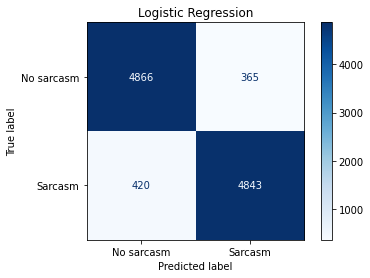

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test_vecs,
        y_test,
        display_labels=['No sarcasm', 'Sarcasm'],
        cmap=plt.cm.Blues )
disp.ax_.set_title("Logistic Regression")
plt.show()

### Naive Bayes

In [ ]:
hyperparams_nb = {
        'var_smoothing': np.logspace(-9,-9, num=100)
}


In [ ]:
clf_nb =RandomizedSearchCV(GaussianNB(), hyperparams_nb, verbose=1,cv=pds,
                           scoring='f1', n_jobs=-1, n_iter=100 ) 

In [ ]:
clf_nb.fit(np.vstack((X_train_vecs, X_valid_vecs)), y_train.append(y_valid))

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1...
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09])},
                   scoring='f1', verbose=1)

In [ ]:
preds = clf_nb.predict(X_test_vecs)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      6732
           1       0.58      0.81      0.67      3762

    accuracy                           0.72     10494
   macro avg       0.72      0.74      0.71     10494
weighted avg       0.76      0.72      0.73     10494



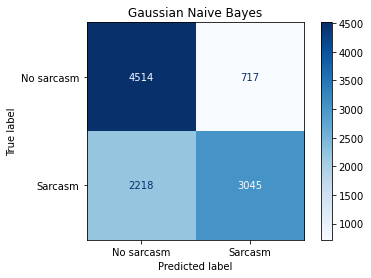

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf_nb,
        X_test_vecs,
        y_test,
        display_labels=['No sarcasm', 'Sarcasm'],
        cmap=plt.cm.Blues )
disp.ax_.set_title("Gaussian Naive Bayes")
plt.show()

### Suport Vector Machine (SVM)

In [ ]:
hyperparams_SVM =   {
    'C': np.logspace(-5, 5, 10), 
    'gamma': np.logspace(-5, 5, 10),
    'kernel': ['rbf', 'linear']} 

In [ ]:
clf_svm =SVC()

In [ ]:
clf_svm.fit(np.vstack((X_train_vecs, X_valid_vecs)), y_train.append(y_valid))

SVC()

In [ ]:
preds = clf_svm.predict(X_test_vecs)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5335
           1       0.95      0.97      0.96      5159

    accuracy                           0.96     10494
   macro avg       0.96      0.96      0.96     10494
weighted avg       0.96      0.96      0.96     10494



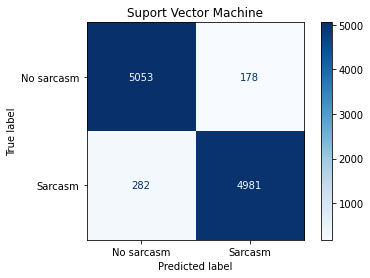

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf_svm,
        X_test_vecs,
        y_test,
        display_labels=['No sarcasm', 'Sarcasm'],
        cmap=plt.cm.Blues )
disp.ax_.set_title("Suport Vector Machine")
plt.show()

In [ ]:
clf_svm.get_params()